# Prediction of permeability in basalts of the Serra Geral Group

- Joao Paulo G. R. Alves - 2024
- joao (dot) guilherme (dot) alves (at) usp (dot) br
- Institute of Energy and Environment - University of Sao Paulo
- This is the full research script, meaning some of the stuff her was not used in the final paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde, pearsonr
import scipy.stats as stats
import statsmodels.api as sm
import os
import shap
import warnings

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# Read data from Excel
df = pd.read_excel("rawdata_permeability.xlsx")
data = df[['density', 'vp', 'porosity', 'permeability']].copy()

In [3]:
# Transform permeability
data['permeability'] = np.log10(data['permeability'])

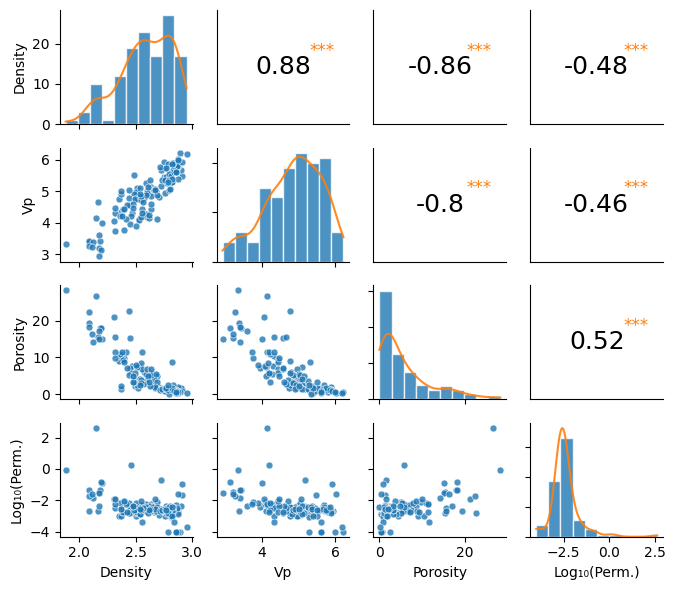

In [4]:
# EDA plot 
data.columns = ['Density', 'Vp', 'Porosity', 'Log10(Permeability)']

# corrdot function to plot correlation coefficient
def corrdot(x, y, ax=None, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 2)
    if ax is not None:
        ax.annotate(corr_text, xy=(0.5, 0.5), xycoords="axes fraction",
                    ha='center', va='center', fontsize=18)

# corrfunc function to plot significance stars
def corrfunc(x, y, ax=None, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05: p_stars = '*'
    if p <= 0.01: p_stars = '**'
    if p <= 0.001: p_stars = '***'
    if ax is not None:
        ax.annotate(p_stars, xy=(0.7, 0.6), xycoords="axes fraction",
                    color='tab:orange', fontsize=12)  # Adjusted for better visibility

n = len(data.columns)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(7, 6))

# Plot each pair of variables
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:  
            counts, bins, patches = axs[i, j].hist(data[data.columns[i]], bins=10, color='tab:blue', alpha = 0.8, edgecolor='white')
            if j == 0:
                axs[i, j].xaxis.set_ticklabels([])
            elif j == n-1:
                axs[i, j].yaxis.set_ticklabels([])
            else:
                axs[i, j].xaxis.set_ticklabels([])
                axs[i, j].yaxis.set_ticklabels([])
            # KDE
            kde = gaussian_kde(data[data.columns[i]])
            x_range = np.linspace(bins.min(), bins.max(), 100)

            # Scale KDE by the count to match histogram scale
            kde_values = kde(x_range) * sum(counts) * np.diff(bins)[0]

            axs[i, j].plot(x_range, kde_values, color='tab:orange', alpha = 0.9)
            
        elif j > i:
            # Correctly pass the axis to the functions
            corrdot(data[data.columns[i]], data[data.columns[j]], ax=ax)
            corrfunc(data[data.columns[i]], data[data.columns[j]], ax=ax)
            axs[i, j].set_facecolor('white')
            for spine in axs[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('black')
            axs[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].scatter(data[data.columns[j]], data[data.columns[i]], color='tab:blue', 
                              edgecolor='white', alpha=0.8, linewidth=0.5, s = 25)

        # Add labels to the leftmost and bottom subplots
        if i == n - 1:
            if data.columns[j] == 'Log10(Permeability)':
                axs[i, j].set_xlabel('Log₁₀(Perm.)')
            else:
                axs[i, j].set_xlabel(data.columns[j])
                
        if j == 0:
            if data.columns[i] == 'Log10(Permeability)':
                axs[i, j].set_ylabel('Log₁₀(Perm.)')  # LaTeX for y-axis label
            else:
                axs[i, j].set_ylabel(data.columns[i])
                
        axs[i, j].spines[['right', 'top']].set_visible(False)

        if i == n-1 and j != 0:
            axs[i, j].yaxis.set_ticklabels([])

        if j == 0 and i != n-1:
            axs[i, j].xaxis.set_ticklabels([])

        if i != n-1 and j != 0:
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
        
plt.tight_layout()
plt.show()

In [5]:
data.head()

Density        Vp  Porosity  Log10(Permeability)
0  2.573227  4.799273  6.083408            -2.703059
1  2.471437  4.316942  7.667464            -2.468521
2  2.447632  3.964627  7.219076            -2.408223
3  2.602406  4.182352  5.566899            -2.469041
4  2.526487  4.128584  7.447569            -2.709423

In [6]:
X = data.drop(columns = ['Log10(Permeability)'])
y = data['Log10(Permeability)']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
# Function to preprocess a dataframe
def preprocess_data(X, scaler=None, vp_dens_scaler=None):
    # Apply transformations
    X_transformed = X.copy()
    X_transformed['Porosity'] = np.sqrt(X_transformed['Porosity'])
    X_transformed['Vp'] = np.sqrt(np.max(X_transformed['Vp'] + 1) - X_transformed['Vp'])
        
    # Initialize MinMaxScaler for the main transformations if not provided
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(X_transformed)  # Fit scaler to the data
        X_scaled = scaler.transform(X_transformed)
    else:
        X_scaled = scaler.transform(X_transformed)  # Transform data using the existing scaler
    
    # Convert the scaled array back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_transformed.columns, index=X_transformed.index)
    X_scaled_df['vp_dens'] = (X_scaled_df['Vp'] * X_scaled_df['Density']) ** 2

    # Initialize MinMaxScaler for 'vp_dens' if not provided
    if vp_dens_scaler is None:
        vp_dens_scaler = MinMaxScaler()
        vp_dens_scaler.fit(X_scaled_df[['vp_dens']])  # Fit scaler to 'vp_dens'
        X_scaled_df['vp_dens'] = vp_dens_scaler.transform(X_scaled_df[['vp_dens']])
    else:
        X_scaled_df['vp_dens'] = vp_dens_scaler.transform(X_scaled_df[['vp_dens']])  # Transform 'vp_dens' using the existing scaler

    return X_scaled_df, scaler, vp_dens_scaler

In [9]:
X_train_transformed, scaler, scaler1 = preprocess_data(X_train)

In [10]:
X_test_transformed, _, _ = preprocess_data(X_test, scaler, scaler1)

In [11]:
# Criteria for weights
some_threshold = 0.5  
high_weight = 2  # Weight for values above the threshold
low_weight = 1  # Weight for values below the threshold

sample_weights = np.where(y_train < some_threshold, low_weight, high_weight)

In [12]:
models = [
    (GradientBoostingRegressor(random_state=42), {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestRegressor(random_state=42), {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 6, 8], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (SVR(), {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}),
    (LinearRegression(), {}),
    (Ridge(), {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']}),
    (ExtraTreeRegressor(random_state=42), {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (BaggingRegressor(random_state=42), {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.7, 1.0], 'max_features': [0.5, 0.7, 1.0]}),
    (XGBRegressor(random_state=42), {'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.7, 0.8], 'max_depth': [3, 5, 7, 9], 'subsample': [0.5, 0.55, 0.6, 0.65, 0.7, 0.8], 'min_child_weight': [1, 2, 4, 6, 8], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}),
    (Lasso(), {'alpha': [0.1, 1.0, 10.0], 'selection': ['cyclic', 'random']}),
    (DecisionTreeRegressor(random_state=42), {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
]

In [14]:
results = []

In [15]:
for model, param_grid in models:
    model_name = model.__class__.__name__
    grid_search = GridSearchCV(estimator=model, 
                                 param_grid=param_grid,  
                                 cv=3,
                                 n_jobs=-1,
                                 verbose=2, 
                                 scoring='neg_mean_squared_error')
    
    grid_search.fit(X_train_transformed, y_train, sample_weight=sample_weights)
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test_transformed)
    
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    
    results.append([model_name, rmse, mae, r2])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=3


243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/home/joao/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/joao/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/joao/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/joao/anaconda3/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constra

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ................C=0.1, epsilon=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ................C=0.1, epsilon=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, epsilon=0.1, 

In [16]:
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])

In [17]:
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

In [18]:
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

Model Performance Comparison:
                    Model     RMSE      MAE       R2
    RandomForestRegressor 0.379510 0.295299 0.671924
             XGBRegressor 0.431517 0.339621 0.575845
         BaggingRegressor 0.454277 0.357040 0.529924
    DecisionTreeRegressor 0.459396 0.352246 0.519268
                    Ridge 0.529461 0.364670 0.361449
GradientBoostingRegressor 0.534782 0.386842 0.348550
                      SVR 0.542839 0.368155 0.328773
         LinearRegression 0.552249 0.432201 0.305299
                    Lasso 0.622934 0.404034 0.116082
       ExtraTreeRegressor 0.658013 0.384039 0.013729
